# SPATIAL TRANSFORMER NETWORKS 

The idea of spatial transformer networks or STNs was introduced by DeepMind, it makes use of image transformations specifically, Affine Transformation to transform the image feature map. We can also say that spatial transformer networks are a generalization of differentiable attention to any spatial transformation.  Spatial transformer networks (STNs) teach a neural network how to make spatial transformations on an input image to improve the model's geometric invariance. It can, for example, crop a specific area of interest, scale, and rotate an image. Because CNNs are not invariant to rotation, scaling, and other affine transformations, it can be a valuable method. Further details can be explored in the paper Spatial Transformer Networks (https://arxiv.org/abs/1506.02025)

One of the best features of STN is that it can be easily integrated into any existing CNN.

In [25]:
from IPython.display import Image
Image(url= "stn.png")

Now let's see these networks in working. 

# Importing The Required Liberaries of PyTorch.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import torch.nn.modules.conv as conv
import torch.utils.data as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
plt.ion() 

# Loading The Data

The dataset we have used in our experiments is MNIST dataset. The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [26]:
Image(url= "mnist.png")

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.ColorJitter(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

# Spatial Transformer Networks Used

There are three fundamental components to spatial transformer networks: 

1. The transformation parameters are regressed by the localization network, which is a normal CNN. The network learns the spatial transformations automatically, which improves the global accuracy, rather than learning them explicitly from this dataset. 
2. The grid generator creates a grid in the input image that corresponds to each pixel in the output image. 
3. The sampler takes the transformation's parameters and applies them to the input image.

Here the network we have used contains two 2D convolution layers followed by dropout and linear units.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


model = Net().to(device)

# Training The Model

Let's now train the model with the SGD technique. The network is supervised in its categorization task learning. Simultaneously, the model is learning STN in a complete end-to-end manner.

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Testing The Model

A simple test procedure to measure the STN performances on MNIST.

In [5]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        y_pred = []
        y_true = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            y_pred.append(pred)
            y_true.append(target.view_as(pred))
        y_pred = np.squeeze(torch.cat(y_pred, dim=0).detach().cpu().numpy(), axis=1)
        y_true = np.squeeze(torch.cat(y_true, dim=0).detach().cpu().numpy(), axis=1)

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        
        # Evaluating precision, recall, f1_score and support.
        p, r, f1, sp = precision_recall_fscore_support(y_true, y_pred)
        precision = np.mean(p, axis=None, dtype=None) 
        recall = np.mean(r, axis=None, dtype=None)
        f1_score = np.mean(f1, axis=None, dtype=None)
        support = np.mean(sp, axis=None, dtype=None)

        print('\Other evaluation metrics on test set: Precision: {}, Recall: {}, F1_Score: {}'
              .format(precision, recall, f1_score))

# Visualizing The STN Results

Now we'll look at the outcomes of our newly acquired visual attention mechanism. 

To view the transformations while training, we construct a tiny helper function.

/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322321
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.739063


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2255, Accuracy: 9344/10000 (93%)

\Other evaluation metrics on test set: Precision: 0.9344505810099226, Recall: 0.9337520855087857, F1_Score: 0.933748487189489


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.436963
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.358171


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1188, Accuracy: 9658/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9656672597261797, Recall: 0.9655159768138395, F1_Score: 0.9654960673558459


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.261938
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.243450


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0948, Accuracy: 9705/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9701606404788207, Recall: 0.9703075691283711, F1_Score: 0.9702026811526097


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.401818
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.062561


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0903, Accuracy: 9702/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9704059816408062, Recall: 0.9698424767254284, F1_Score: 0.970057779059947


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.210971
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.239524


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1036, Accuracy: 9655/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9659227740913574, Recall: 0.9653100932043082, F1_Score: 0.9653904187431633


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 6 [0/60000 (0%)]	Loss: 0.437226
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.194570


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0648, Accuracy: 9799/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9799891964498011, Recall: 0.979815648406051, F1_Score: 0.979870433521986


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 7 [0/60000 (0%)]	Loss: 0.128018
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.120947


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1128, Accuracy: 9674/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9677644679301046, Recall: 0.9673058638085117, F1_Score: 0.9673152706134595


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 8 [0/60000 (0%)]	Loss: 0.157521
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.158863


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0548, Accuracy: 9835/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.983439182304059, Recall: 0.9834032725917805, F1_Score: 0.9834078621160925


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 9 [0/60000 (0%)]	Loss: 0.120987
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.576948


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0719, Accuracy: 9780/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9779781352097162, Recall: 0.9778961110831939, F1_Score: 0.9778852563856232


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 10 [0/60000 (0%)]	Loss: 0.036444
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.132190


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0538, Accuracy: 9831/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9831928667930573, Recall: 0.9828701513933614, F1_Score: 0.98300295386285


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 11 [0/60000 (0%)]	Loss: 0.065924
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.088788


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0469, Accuracy: 9863/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9862532378029234, Recall: 0.9862284535979136, F1_Score: 0.9862347974136718
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.088910


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.109385


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0540, Accuracy: 9837/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9837676390194783, Recall: 0.9836192009495986, F1_Score: 0.9836616037390093


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 13 [0/60000 (0%)]	Loss: 0.106922
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.033514


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0451, Accuracy: 9861/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9860629344649278, Recall: 0.9860623981927426, F1_Score: 0.9860610840164732


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 14 [0/60000 (0%)]	Loss: 0.033699
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.148232


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0451, Accuracy: 9861/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9861650951904568, Recall: 0.9860038276464363, F1_Score: 0.9860738007122212


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 15 [0/60000 (0%)]	Loss: 0.049242
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.112875


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0549, Accuracy: 9833/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9833105221755213, Recall: 0.9832957164215566, F1_Score: 0.9832845697442856


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 16 [0/60000 (0%)]	Loss: 0.083733
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.026786


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0457, Accuracy: 9847/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.984598797114556, Recall: 0.9846736505820012, F1_Score: 0.9846226581682233


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 17 [0/60000 (0%)]	Loss: 0.037359
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.201926


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0432, Accuracy: 9874/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9874817367934853, Recall: 0.9872745102043694, F1_Score: 0.9873704595183135


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 18 [0/60000 (0%)]	Loss: 0.163957
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.043772


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0492, Accuracy: 9847/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9848060305626267, Recall: 0.9846456543116343, F1_Score: 0.9847012425390913


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 19 [0/60000 (0%)]	Loss: 0.049057
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.105576


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0412, Accuracy: 9875/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9875492808943823, Recall: 0.9873593171213464, F1_Score: 0.9874476635393623


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 20 [0/60000 (0%)]	Loss: 0.048036
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.014979


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0431, Accuracy: 9874/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9874660514139746, Recall: 0.9873483543994912, F1_Score: 0.9873888550311781


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


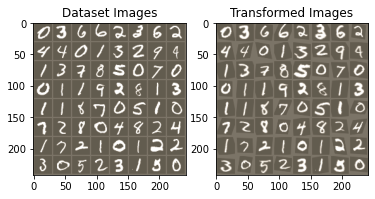

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20+1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# CoordConv By UBER AI Labs

A CoordConv layer is a straightforward addition to a conventional convolutional layer. It has the same functional signature as a convolutional layer, but it maps the input representation by concatenating extra channels beforehand. These channels include hard-coded coordinates, with one channel for the i coordinate and another for the j coordinate in the most basic version.

The CoordConv layer preserves the properties of few parameters and efficient convolutional processing, but it also allows the network to learn whether to keep or reject translation invariance depending on the task at hand. This is beneficial for problems involving coordinate transforms, when ordinary convolutions may fail.


In [27]:
Image(url= "coordconv_uber.png")

From creating self-driving vehicles to automating street sign identification to building maps and increasing the efficiency of spatial motions in the Uber Marketplace, Uber uses convolutional neural networks in a variety of domains that could potentially require coordinate transforms.

In there work in "An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution" (https://arxiv.org/abs/1807.03247) they have proposed three discoveries which are as follows:

First discovery: supervised rendering is hard for CNNs

Second discovery: supervised coordinate classification is hard for CNNs

Third discovery: supervised regression is also hard for CNNs

And they proposed a solution to these three problems with CoordConv.

# Importing The Architecture For Coordconv

In [3]:
from coordconv import *

# You can get this file from the PyTorch implementation of CoordConv by 
# LeVirve Salas, Valentin Peretroukhin and Christian Clauss (https://github.com/mkocabas/CoordConv-pytorch).

# Spatial Transformer Networks With CoordConv

Here we are using the same special transformer network that we have used in our previous experiments but we also added a layer of coordconv in the network.

Now the network have one coordconv layer followed by two 2D convolution layers followed by a dropout and linear units.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.coordconv = CoordConv2d(1, 10, 1, with_r=True, use_cuda=False)
        self.conv1 = nn.Conv2d(10, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = self.coordconv(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


model = Net().to(device)

# Training And Testing The Model

The training and testing of procedure is the same as pervious experiment.

In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        y_pred = []
        y_true = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
#             print(pred.shape)
            y_pred.append(pred)
            y_true.append(target.view_as(pred))
        y_pred = np.squeeze(torch.cat(y_pred, dim=0).detach().cpu().numpy(), axis=1)
        y_true = np.squeeze(torch.cat(y_true, dim=0).detach().cpu().numpy(), axis=1)
    
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        
        # Evaluating precision, recall, f1_score and support.
        p, r, f1, sp = precision_recall_fscore_support(y_true, y_pred)
        precision = np.mean(p, axis=None, dtype=None) 
        recall = np.mean(r, axis=None, dtype=None)
        f1_score = np.mean(f1, axis=None, dtype=None)
        #support = np.mean(sp, axis=None, dtype=None)
        
        print('\Other evaluation metrics on test set: Precision: {}, Recall: {}, F1_Score: {}'
              .format(precision, recall, f1_score))

# Visualizing The STN Results

Now we'll look at the outcomes of our newly acquired visual attention mechanism.

To view the transformations while training, we construct a tiny helper function.

/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302411
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.169425


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2817, Accuracy: 9189/10000 (92%)

\Other evaluation metrics on test set: Precision: 0.918133172190194, Recall: 0.9185610056394967, F1_Score: 0.9176106999103529


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.539881
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.587565


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1642, Accuracy: 9488/10000 (95%)

\Other evaluation metrics on test set: Precision: 0.9486413500044437, Recall: 0.9489897108778352, F1_Score: 0.9481614629257848


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.557945
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.202659


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1046, Accuracy: 9658/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.965564996855972, Recall: 0.9654092587329387, F1_Score: 0.9652152761254106


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.304623
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.211075


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1752, Accuracy: 9474/10000 (95%)

\Other evaluation metrics on test set: Precision: 0.9494090058417408, Recall: 0.946892184267828, F1_Score: 0.9470737562677192


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 5 [0/60000 (0%)]	Loss: 0.344061
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.123622


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1118, Accuracy: 9671/10000 (97%)

\Other evaluation metrics on test set: Precision: 0.9671372216043407, Recall: 0.967254304780678, F1_Score: 0.9669546509517964


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 6 [0/60000 (0%)]	Loss: 0.229694
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.101168


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0586, Accuracy: 9826/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9824931150493186, Recall: 0.982728760109848, F1_Score: 0.9825947297121157


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 7 [0/60000 (0%)]	Loss: 0.350877
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.073199


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0567, Accuracy: 9834/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9833322582026327, Recall: 0.9833525711582347, F1_Score: 0.9833330715625982


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 8 [0/60000 (0%)]	Loss: 0.212894
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.156650


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0744, Accuracy: 9769/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9771203045943702, Recall: 0.9767696891468202, F1_Score: 0.9768564918669377


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 9 [0/60000 (0%)]	Loss: 0.066224
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.225468


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0555, Accuracy: 9840/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9840274176462233, Recall: 0.9839921251283436, F1_Score: 0.983981202600447


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 10 [0/60000 (0%)]	Loss: 0.246771
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.175425


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0528, Accuracy: 9836/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9835783659768478, Recall: 0.9836548988731189, F1_Score: 0.9835971592328429


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 11 [0/60000 (0%)]	Loss: 0.087281
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.091650


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0557, Accuracy: 9830/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9831474295322863, Recall: 0.9829609632135069, F1_Score: 0.983028568517639


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 12 [0/60000 (0%)]	Loss: 0.223113
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.260903


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0520, Accuracy: 9849/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9849243271812641, Recall: 0.9849662862484558, F1_Score: 0.9849294417933571


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 13 [0/60000 (0%)]	Loss: 0.131079
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.149385


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0491, Accuracy: 9862/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9863121371345287, Recall: 0.9861208505788644, F1_Score: 0.9861921497733442


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 14 [0/60000 (0%)]	Loss: 0.188988
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.070888


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0480, Accuracy: 9847/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9847808485451918, Recall: 0.9845338700020996, F1_Score: 0.984633414729123


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 15 [0/60000 (0%)]	Loss: 0.084795
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.188280


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0462, Accuracy: 9867/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9867147264874901, Recall: 0.9866151778068175, F1_Score: 0.9866556394156095


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 16 [0/60000 (0%)]	Loss: 0.081486
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.133723


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0573, Accuracy: 9822/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9822418009637331, Recall: 0.982027947318322, F1_Score: 0.9820869443250532


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 17 [0/60000 (0%)]	Loss: 0.104191
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.063813


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0422, Accuracy: 9877/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9876759617931368, Recall: 0.987711460800314, F1_Score: 0.9876836652902293


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 18 [0/60000 (0%)]	Loss: 0.156750
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.012955


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0436, Accuracy: 9877/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9877682253801483, Recall: 0.9876724444609746, F1_Score: 0.9877090614716508


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 19 [0/60000 (0%)]	Loss: 0.055265
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.040758


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0499, Accuracy: 9850/10000 (98%)

\Other evaluation metrics on test set: Precision: 0.9849797375368908, Recall: 0.9849371695738807, F1_Score: 0.9849399441915713


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 20 [0/60000 (0%)]	Loss: 0.131811
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.054197


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0404, Accuracy: 9870/10000 (99%)

\Other evaluation metrics on test set: Precision: 0.9869704863250975, Recall: 0.9868966263053321, F1_Score: 0.9869170614800101


/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/Users/siddhantbhambri/anaconda3/envs/env5/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


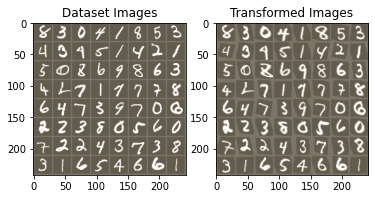

In [6]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()


# Proposed Ideas and Solutions:

# Some Proposed Pre-Processing Steps For Better Performance

When the object is the image alone, neural networks for image classification will be able to train faster and better. As a result, eliminating the backgrounds from photographs is a very useful pre-processing step.

Let's See this with an example.

In [30]:
Image(url= "id1.jpg")

From the above figure we can conclude that the background information is mostly unnessery for a network so it is much better way to make the models efficent by applying the background removal on the data.

Here I am proposing a simple way to do that by using OpenCV.

In [31]:
Image(url= "bgr.png")

Detailed code and implementation of this work can we found in another jupyter notebook named "Background_removal.ipynb"

There are many other works that can be explored for better performance and better results.

# Noise Reduction

In [32]:
Image(url= "dni.png")

One more preprocessing step can be added in the process because the person taking the image of the id card can have a bad camera which can be adding noise to the image. so anether step could be removing the noise from the image. That can be done by many ways, here I am showing to remove the sault and papper noise from the image to make it more smoother. The detailed code for the same can be found in "denoise.ipynb" notebook.

After applying all the above preprocessing steps now we can discuss the approaches that can be explored which can be helpfull in identity varification using vision.

# Text Isolation For Detailed Review

One of the approach that I would like to propose is the text isolation which cluld help in detailed review of the documents to make the processing fast and accurate. It could also help in forgery detection in the text.

In my openion applying STN along with text isolation algorithms could really helpful for analysing the documents in a better way. With the help of this we can exacty deine where we actually have to target.

One of the major aplication of STNs in identity varification could be that it is not always nessery that the person who take image of his identity paperwork will take it in a proper manner, like keeping all the lines parallel, and not taking images in a different allignment. STNs can be used to correct that and improve the performance of the networks. Allignment of text and data on the document can also be used to identify the accuracy and genuinity of the document.

One of the text detection algorithm I have explored is the "TextSnake: A Flexible Representation for Detecting Text of Arbitrary Shapes (2020) (https://arxiv.org/abs/1807.01544)". The method is capable enough for isolating text and its neighbouring region. It can be seen from the results given below.

The algorithm is also capable enough to isolate any shape and structure of text which makes it a generalised way for detecting text.

In [33]:
Image(url= "txi.png")

From the above image we can see that the method is capable enough to detect text and can be used to create the binary masks for the text region. Applying STN's with such kind of algorithms can be helpful for detailed analysis of the documents.

In [34]:
Image(url= "txi2.png")

Text isolation using OCR can also be used further using thresholding on the pixels for binary mask generation can also be used but it is more helpful if the text is straight in line.

# Algorithm Deployed On A Real Life Condition:

In [8]:
from IPython.display import Image
Image(url= "ve1.png")

# SIFT (Scale-Invariant Feature Transform)

The scale-invariant feature transform (SIFT) is a computer vision algorithm to detect, describe, and match local features in images.

The biggest advantage of the SIFT is that they proposed the concept of Distinctive Image Features from Scale-Invariant key-points which proved to be an advantage in the conditions when the images are having different augmentations like rotation, scaling, etc.

In [9]:
Image(url= "sift.png")

• Scale-Space Extrema Detection: In SIFT algorithm to detect larger corners we need larger windows. For this, scale-space filtering is used.

• Keypoint Localization: Once potential keypoints locations are found, they have to be refined to get more accurate results. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected.

• Orientation Assignment: Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neighborhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region.

• Keypoint Descriptor: Now keypoint descriptor is created. A 16x16 neighbourhood around the keypoint is taken. It is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created.

• Keypoint Matching: Keypoints between two images are matched by identifying their nearest neighbours.


This is one of the approach I would like to propose which could be very helpfull in detecting minute things in the documentation. It is also invariant to augmentations hence could be used. The results shown above are on painting dataset and it can be seen that the scale is not a problem here.